In [1]:
import glob
import os
import time

# from tqdm import tnrange, tqdm_notebook
from tqdm import tqdm

# from skimage.transform import resize
# from skimage import data, color

import tensorflow.keras.backend as K
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout,BatchNormalization,Activation,PReLU,LeakyReLU, Add
from tensorflow.keras.layers import UpSampling2D, Conv2D, MaxPooling2D, Conv2DTranspose, GlobalAveragePooling2D, ZeroPadding2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

# from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras import initializers
from tensorflow.keras.models import load_model

from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.utils import HDF5Matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.utils import shuffle

In [2]:
def init_folders(name):
    if not os.path.exists('results'):
        os.mkdir('results')
    if not os.path.exists('results/'+name):
        os.mkdir('results/'+name)
        
def save_loss(name, epoch, Dloss, Gloss):
    path = 'results/'+name+'/loss'
    if not os.path.exists(path):
        os.mkdir(path)
    plt.figure(figsize=(10,8))
    plt.plot(Dloss,label='Dsicriminiative loss')
    plt.plot(Gloss,label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(path+'/loss_%d.png' % epoch)
    
def save_samples(folder, w, h, c, epoch, G,example=16, dim=(10,10),figsize=(10,10), randomDim=100):
    noise = np.random.normal(0,1,size=(example,randomDim))
    generatedImage = G.predict(noise)
    
    plt.figure(figsize=figsize)
    
    for i in range(example):
        plt.subplot(dim[0],dim[1],i+1)
        plt.imshow((generatedImage[i]* 127.5+127.5).astype(np.int32),interpolation='nearest',cmap='gray')
        '''drop the x and y axis'''
        plt.axis('off')
    plt.tight_layout()
    
    path = 'results/'+folder+'/samples'
    if not os.path.exists(path):
        os.mkdir(path)
    plt.savefig(path+'/epoch_%d.png' % epoch)
    
def save_models(name, epoch, d=None, g=None):
    path = 'results/'+name+'/models'
    if not os.path.exists(path):
        os.mkdir(path)
    g.save(path+'/G_%d.h5' % epoch)
    d.save(path+'/D_%d.h5' % epoch)
    
def get_model_memory_usage(batch_size, model):
    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    number_size = 4.0
    if K.floatx() == 'float16':
         number_size = 2.0
    if K.floatx() == 'float64':
         number_size = 8.0

    total_memory = number_size*(batch_size*shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes


# class CustomDataProvider:
#     def __init__(self, batch_size):
#         self.batch_size = batch_size
#         self.file = h5py.File('camelyonpatch_level_2_split_train_x.h5', 'r')
#         self.dataset = self.file['x']
#         self.input_shape = self.dataset[0].shape
#         self.image_number = self.dataset.shape[0]
        
#     def sample(self):
#         random_index = np.random.randint(0, self.image_number - self.batch_size)
#         return (self.dataset[random_index : random_index +  self.batch_size] - 127.5) / 127.5
        
#     def close(self):
#         if self.file:
#             self.file.close()
#         self.file = None
        
#     def __del__(self):
#         self.close()

class PcamDataProvider:
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.file = h5py.File('camelyonpatch_level_2_split_train_x.h5', 'r')
        self.dataset = self.file['x']
        self.input_shape = self.dataset[0].shape
        self.image_number = self.dataset.shape[0]
        
    def sample(self):
        random_index = np.random.randint(0, self.image_number - self.batch_size)
        return (self.dataset[random_index : random_index +  self.batch_size] - 127.5) / 127.5
        
    def close(self):
        if self.file:
            self.file.close()
        self.file = None
        
    def __del__(self):
        self.close()
        
def crop_generator(batches):
    while True:
        batch_x, batch_y = next(batches)
        yield (batch_x[:, 16:80,16:80], batch_y)

In [3]:
def create_generic_CNN(width, height, channels):
    kernel_size=3
    model = Sequential()

    model.add(Conv2D(32, kernel_size=kernel_size, input_shape=(width, height, channels), padding="same", activation='elu'))
    model.add(MaxPooling2D(pool_size = 3))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))

    model.add(Conv2D(64, kernel_size=kernel_size, padding="same", activation='elu'))
    model.add(MaxPooling2D(pool_size = 3))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))

    model.add(Conv2D(128, kernel_size=kernel_size, padding="same", activation='elu'))
    model.add(MaxPooling2D(pool_size = 3))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    
    return model

def create_CNN(width, height, channels, n_classes=2, gpus=8):

    model = create_generic_CNN(width, height, channels)
    model.add(Flatten())
    model.add(Dense(128, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    
    loss='binary_crossentropy'
    if n_classes == 2:
        model.add(Dense(1, activation='sigmoid'))
    else:
        model.add(Dense(n_classes, activation='softmax'))
        loss = 'categorical_crossentropy'
        
    if gpu!=1:
        model = multi_gpu_model(model, gpus=gpus)
    
    model.compile(loss=loss,optimizer='adam', metrics=['accuracy'])


#     print('Critic')
    model.summary()

    return model

def create_GAP_CNN(width, height, channels, n_classes=2, gpus=8):
    model = create_generic_CNN(width, height, channels)
    
    model.add(GlobalAveragePooling2D())
    
    
    loss='binary_crossentropy'
    if n_classes == 2:
        model.add(Dense(1, activation='sigmoid'))
    else:
        model.add(Dense(n_classes, activation='softmax'))
        loss = 'categorical_crossentropy'
        
    if gpu!=1:
        model = multi_gpu_model(model, gpus=gpus)
    
    model.compile(loss=loss,optimizer='adam', metrics=['accuracy'])

#     print('Critic')
    model.summary()

    return model

def create_SG_G(width, height, channels, latent_dim):

    model = Sequential()
    
    model.add(Dense(32*int(width/4)*int(height/4), input_dim=latent_dim))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    model.add(Reshape((int(width/4),int(height/4), 32)))

    model.add(UpSampling2D())
#     model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(64, kernel_size=3, strides=1, padding="same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))

    model.add(UpSampling2D())
#     model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(48, kernel_size=4, strides=2, padding="same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    
    model.add(UpSampling2D())
#     model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(32, kernel_size=3, strides=1, padding="same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))

    model.add(UpSampling2D())
#     model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(16, kernel_size=4, strides=2, padding="same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
 
    model.add(Conv2D(8, kernel_size=3, strides=1, padding="same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))

    model.add(UpSampling2D())
#     model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(16, kernel_size=4, strides=2, padding="same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    
    model.add(Conv2D(channels, kernel_size=3, strides=1, padding="same"))
    model.add(Activation("tanh"))

    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

def create_SG_D(width, height, channels):

    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(width, height, channels), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())

    model.summary()

    img = Input(shape=(width, height, channels))

    features = model(img)
    valid = Dense(1, activation="sigmoid")(features)
    label = Dense(3, activation="softmax")(features)

    return Model(img, [valid, label])

def crate_SGGAN(width, height, channels, latent_dim=128, gpus=8):
        discriminator = create_SG_D(width, height, channels)
#         discriminator = multi_gpu_model(discriminator, gpus=gpus)
        
        optimizer='adam'

        discriminator.compile(
            loss=['binary_crossentropy', 'categorical_crossentropy'],
            loss_weights=[0.5, 0.5],
            optimizer=optimizer,
            metrics=['accuracy']
        )

        # Build the generator
        generator = create_SG_G(width, height, channels, latent_dim)

        # The generator takes noise as input and generates imgs
        noise = Input(shape=(latent_dim,))
        img = generator(noise)

        # For the combined model we will only train the generator
        discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid, _ = discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        combined = Model(noise, valid)
#         combined = multi_gpu_model(combined, gpus=gpus)
        combined.compile(loss=['binary_crossentropy'], optimizer=optimizer)
        return discriminator, generator, combined


In [4]:
x_train = (h5py.File('camelyonpatch_level_2_split_train_x.h5', 'r')['x'][:, 16:80,16:80]- 127.5) / 127.5
y_train = h5py.File('camelyonpatch_level_2_split_train_y.h5', 'r')['y'].value.reshape(-1,1)
x_valid = (h5py.File('camelyonpatch_level_2_split_valid_x.h5', 'r')['x'][:, 16:80,16:80]- 127.5) / 127.5
y_valid = h5py.File('camelyonpatch_level_2_split_valid_y.h5', 'r')['y'].value.reshape(-1,1)

x_train_10, y_train_10 = shuffle(x_train, y_train, random_state=0)
percent_10 = int(x_train_10.shape[0]*.1)
x_train_10 = x_train_10[:percent_10]
y_train_10 = y_train_10[:percent_10]

/usr/local/lib/python3.5/dist-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [5]:
latent_dim = 128
discriminator, generator, combined = crate_SGGAN(*x_train_10.shape[1:], latent_dim)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 17, 17, 64)        0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 17, 17, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 17, 64)        0         
__________

In [6]:
batch_size = 256
half_batch = batch_size // 2
cw1 = {0: 1, 1: 1}
cw2 = {0: 2/half_batch, 1: 2/half_batch, 2: 1/half_batch}

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

In [7]:
d_loss = []
g_loss = []
for epoch in range(10000):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of images
        idx = np.random.randint(0, x_train_10.shape[0], batch_size)
        imgs = x_train_10[idx]

        # Sample noise and generate a batch of new images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        # One-hot encoding of labels
        labels = to_categorical(y_train_10[idx], num_classes=3)
        fake_labels = to_categorical(np.full((batch_size, 1), 2), num_classes=3)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, [valid, labels], class_weight=[cw1, cw2])
        d_loss_fake = discriminator.train_on_batch(gen_imgs, [fake, fake_labels], class_weight=[cw1, cw2])
        d_loss.append(0.5 * np.add(d_loss_real, d_loss_fake))


        # ---------------------
        #  Train Generator
        # ---------------------

        g_loss.append(combined.train_on_batch(noise, valid, class_weight=[cw1, cw2]))

#         print ("%d [D loss: %f, acc: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss))

#         if epoch % sample_interval == 0:
#             self.sample_images(epoch)

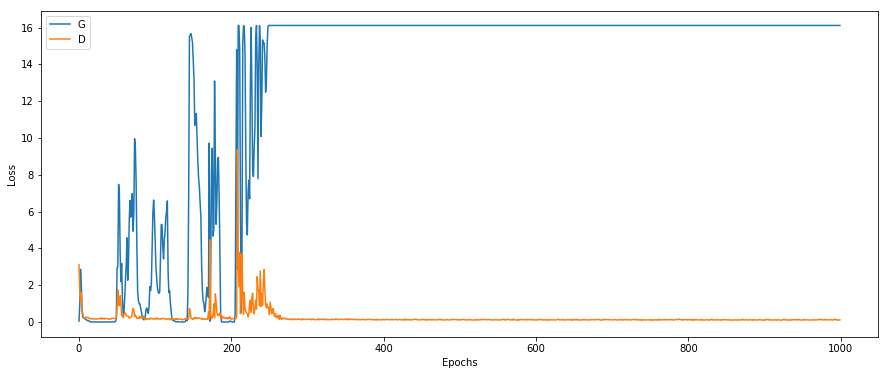

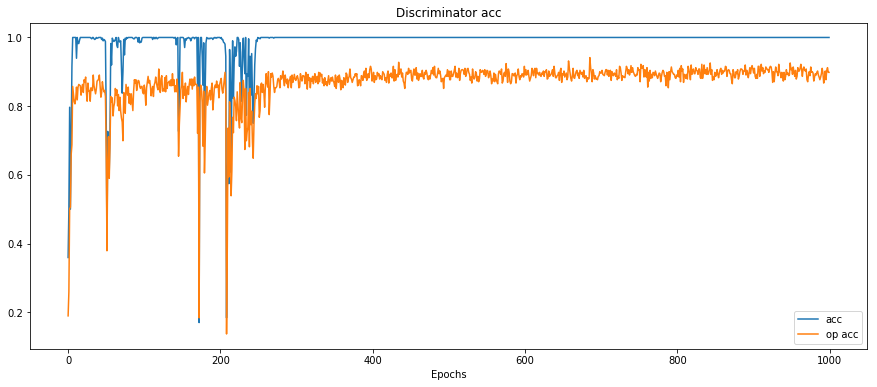

In [8]:
plt.figure(figsize=(15,6))
plt.plot(g_loss, label='G')
plt.plot(np.array(d_loss)[:,0], label='D')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(15,6))

plt.plot(np.array(d_loss)[:,3], label='acc')
plt.plot(np.array(d_loss)[:,4], label='op acc')
plt.xlabel('Epochs')
plt.title('Discriminator acc')
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


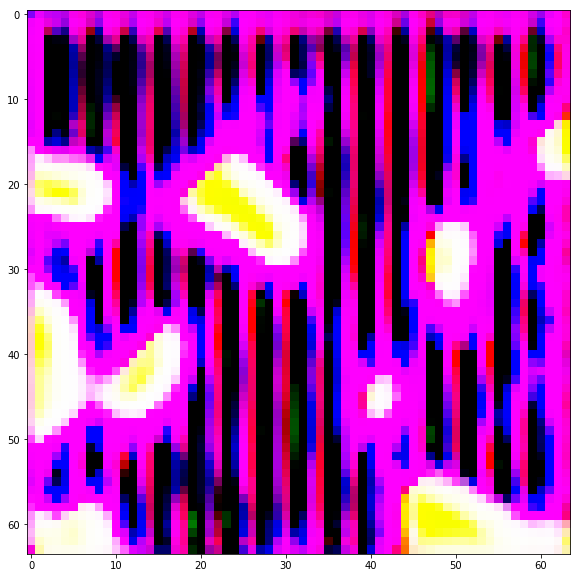

In [9]:
noise = np.random.normal(0, 1, (1, latent_dim))
gen_imgs = generator.predict(noise)
plt.figure(figsize=(10,10))
plt.imshow(gen_imgs[0])

In [12]:
labels = to_categorical(y_valid, num_classes=3)
valid = np.ones((y_valid.shape[0],1))
history = discriminator.evaluate(x_valid,[valid, labels], batch_size=512)

32768/32768 [==============================] - 5s 167us/step


In [33]:
y_valid[:10]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1]], dtype=uint8)

In [10]:
np.array(discriminator.predict(x_valid[6][np.newaxis])[1]).argmax(axis=-1)

array([2])

In [15]:
x_train[0,0,0]

array([0.38039216, 0.16078431, 0.4745098 ])

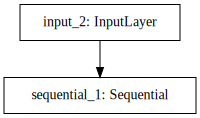

In [11]:
# SVG(model_to_dot(generator).create(prog='dot', format='svg'))

In [14]:
# x_train = h5py.File('camelyonpatch_level_2_split_train_x.h5', 'r')['x'][:, 16:80,16:80]/255.
# y_train = h5py.File('camelyonpatch_level_2_split_train_y.h5', 'r')['y'].value.reshape(-1,1)
# x_train = h5py.File('x_aug.h5', 'r')['x'].value
y_train = h5py.File('y_aug.h5', 'r')['y'].value
x_valid = h5py.File('camelyonpatch_level_2_split_valid_x.h5', 'r')['x'][:, 16:80,16:80]/255.
y_valid = h5py.File('camelyonpatch_level_2_split_valid_y.h5', 'r')['y'].value.reshape(-1,1)

# datagen = ImageDataGenerator(
# #     preprocessing_function=lambda x: x/255.,
#     rotation_range=180,
#     horizontal_flip=True,  # randomly flip images
#     vertical_flip=True)  # randomly flip images

# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 21, 21, 32)        128       
_________________________________________________________________
dropout_4 (Dropout)          (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 64)          256       
__________

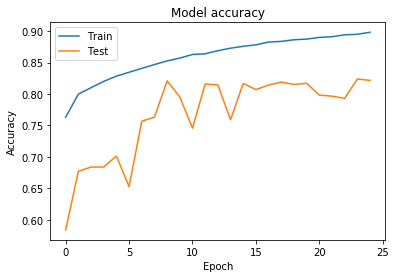

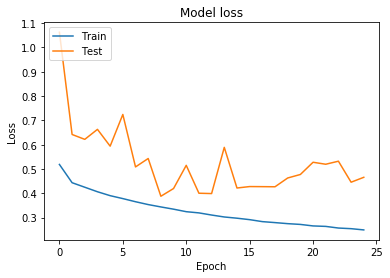

In [7]:
model = create_CNN(64,64,3)


batch_size = 512*8
# training_gen = crop_generator(datagen.flow(x_train, y_train, batch_size=batch_size))
# valid_gen = crop_generator(datagen.flow(x_valid, y_valid, batch_size=batch_size))

checkpoint = ModelCheckpoint('weights.best.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
csv_logger = CSVLogger("model_history_log.csv", append=False)
early = EarlyStopping(monitor='val_loss', patience=16)

history = model.fit(x_train, y_train, batch_size=batch_size,
#                     steps_per_epoch=100, validation_steps = 100,
                    validation_data=(x_valid,y_valid),
                    epochs=1000, callbacks=[checkpoint, csv_logger, early],
                    workers = 72,use_multiprocessing=True
                   )



plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.figure()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

path = 'results/cnn_models'
if not os.path.exists(path):
    os.mkdir(path)
model.save(path+'/cnn_v0.h5')
model.save_weights(path+'/cnn_weights_v0.h5')

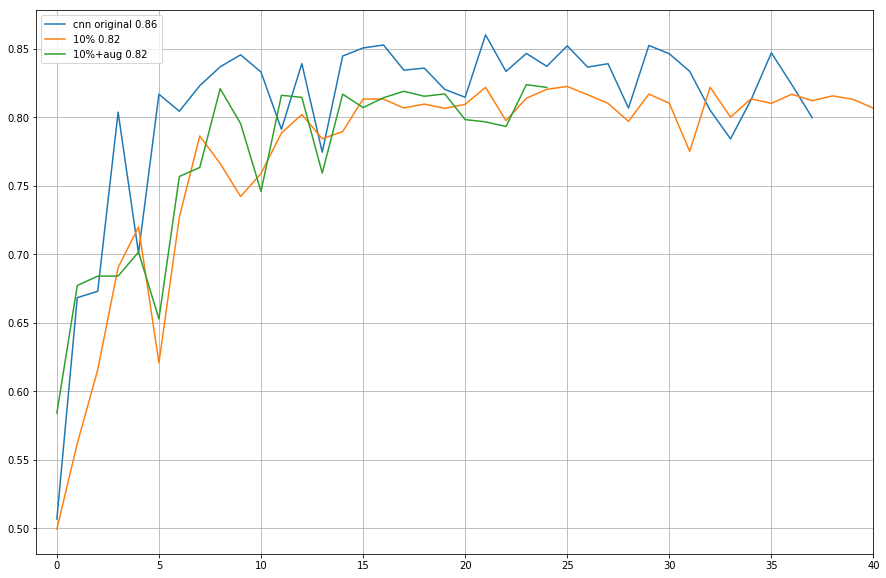

In [17]:
cnn = np.loadtxt('models/cnn_bn/cnn_bn_history.csv', delimiter=',', skiprows=1, usecols=3)
cnn10 = np.loadtxt('models/cnn_bn_10percent/cnn_bn_10percent_history.csv', delimiter=',', skiprows=1, usecols=3)[7::3]
cnn10_aug = np.loadtxt('models/cnn_bn_10percent_aug/cnn_bn_10percent_aug_history.csv', delimiter=',', skiprows=1, usecols=3)

plt.figure(figsize=(15,10))
plt.plot(cnn, label='cnn original {:0.2f}'.format(cnn.max()))
plt.plot(cnn10, label='10% {:0.2f}'.format(cnn10.max()))
plt.plot(cnn10_aug, label='10%+aug {:0.2f}'.format(cnn10_aug.max()))
plt.legend()
plt.xlim(-1,40)
plt.grid()

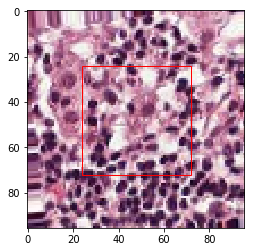

In [169]:
from matplotlib.patches import Rectangle

datagen = ImageDataGenerator(
              preprocessing_function=lambda x: x/255.,
    rotation_range=180,
#               horizontal_flip=True,  # randomly flip images
#               vertical_flip=True
)  # randomly flip images

img = datagen.flow(x_train[10:11])[0][0]
plt.imshow(img)
# Create a Rectangle patch
rect = Rectangle((24,24),48,48,linewidth=1,edgecolor='r',facecolor='none')
ax = plt.gca()
# Add the patch to the Axes
ax.add_patch(rect)

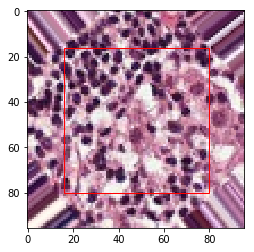

In [139]:
plt.imshow(img)
# Create a Rectangle patch
rect = Rectangle((16,16),64,64,linewidth=1,edgecolor='r',facecolor='none')
ax = plt.gca()
# Add the patch to the Axes
ax.add_patch(rect)

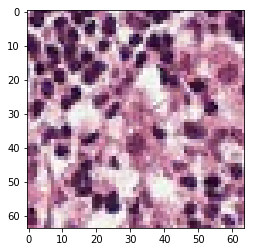

In [145]:
plt.imshow(img[16:16+64, 16:16+64])

16 80 16 80


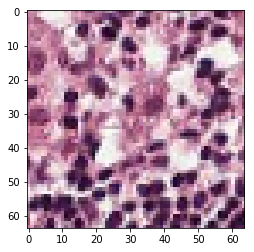

In [170]:
plt.imshow(center_crop(img, 64))

In [183]:
def center_crop(img, new_size):
    x,y,_ = img.shape
    x = x // 2
    y = y // 2
    size = new_size // 2
    return img[x-size:x+size, y-size:y+size]


def crop_generator(batches, new_size):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x = next(batches)
        print(batch_x.shape)
#         batch_crops = np.zeros((batch_x.shape[0], new_size, new_size, 3))
#         for i in range(batch_x.shape[0]):
#             batch_crops[i] = center_crop(batch_x[i], new_size)
        yield (batches[:, 16:80,16:80, :])

(1, 64, 64, 3)


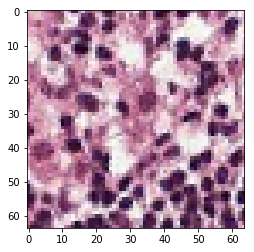

In [184]:
img = next(crop_generator(datagen.flow(x_train[10:11]), 64))[0]
plt.imshow(img)
